#Проект: предсказания победителя в Dota

_Все свои комментарии я буду обозначать курсивом. Некурсив - фрагменты задания._

_Импортируем все необходимые библиотеки_

In [2]:
%pylab inline
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import auc, roc_auc_score
from time import time

Populating the interactive namespace from numpy and matplotlib


# Подход 1: градиентный бустинг "в лоб"
_Считаем данные. Поместим столбец с целевой переменной в отдельную переменную и удалим из датасета признаки, связанные с итогами матча_

In [3]:
data = pd.read_csv('../../data/features.csv', index_col='match_id')
targets = data.radiant_win.values
data.drop(['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 
           'barracks_status_dire'], axis=1, inplace=True)

_Посмотрим какие признаки имеют пропуски_

In [4]:
for field, total in data.count().iteritems():
    if total != len(data):
        print "%30s - %d (%2.2f%s)" % (field, total, 100. * total / len(data), '%') 

              first_blood_time - 77677 (79.89%)
              first_blood_team - 77677 (79.89%)
           first_blood_player1 - 77677 (79.89%)
           first_blood_player2 - 53243 (54.76%)
           radiant_bottle_time - 81539 (83.86%)
          radiant_courier_time - 96538 (99.29%)
   radiant_flying_courier_time - 69751 (71.74%)
       radiant_first_ward_time - 95394 (98.11%)
              dire_bottle_time - 81087 (83.40%)
             dire_courier_time - 96554 (99.30%)
      dire_flying_courier_time - 71132 (73.16%)
          dire_first_ward_time - 95404 (98.12%)


_Заполним нулями пропуски в данных_

In [5]:
data.fillna(0., inplace=True)

_Зафиксируем разбиение по фолдам, чтобы все модели обучились на одном разбиении и было корректно их сравнивать_

In [6]:
n_folds = 5
KF = KFold(len(data), n_folds = n_folds, shuffle=True)

_Проведём кросс-валидацию по 5 фолдам для градиентного бустинга с разным количеством деревьев - 10, 20, 30._

In [6]:
for x in [10,20,30]:
    start = time()
    result = cross_val_score(GradientBoostingClassifier(n_estimators=x), 
                             data.ix[:,:], targets, scoring='roc_auc', cv=KF).mean()
    final = time()
    print "%d trees - AUC=%.6f. time: %.2f sec" % (x, result, final - start)

10 trees - AUC=0.664331. time: 70.31 sec
20 trees - AUC=0.681978. time: 130.04 sec
30 trees - AUC=0.689588. time: 195.87 sec


_Чтобы ответить на вопрос имеет ли смысл добавлять ещё деревья построим графики ошибки на обучающей и тестовой выборке в зависимости от количества деревьев. Границы полупрозрачных областей соответствуют максимуму и минимуму AUC в пределах 5 фолдов для конкретного количества деревьев_

C:\Users\vlad\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


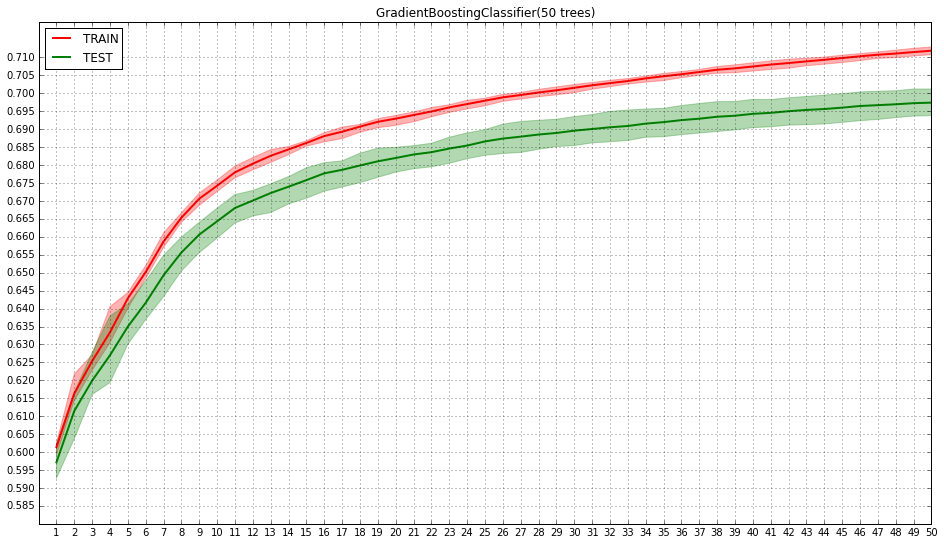

Wall time: 7min 41s


In [7]:
%%time
plt.figure(figsize=(16,9))
for x in [50]:
    i = 0
    AUC_train = pd.DataFrame(columns=['fold' + str(y) for y in xrange(1,n_folds+1)])
    AUC_test = pd.DataFrame(columns=['fold' + str(y) for y in xrange(1,n_folds+1)])
    for train_index, test_index in KF:
        XTrain, XTest = data.iloc[train_index,:], data.iloc[test_index,:]
        YTrain, YTest = targets[train_index], targets[test_index]
        GBC = GradientBoostingClassifier(n_estimators=x, learning_rate=0.1)
        GBC.fit(XTrain, YTrain)
        AUC_test.iloc[:,i] = array([roc_auc_score(YTest, map(lambda z: 1 / (1 + exp(-z)), 
                                                  GBC.staged_decision_function(XTest))[y]) for y in xrange(x)])
        AUC_train.iloc[:,i] = array([roc_auc_score(YTrain, map(lambda z: 1 / (1 + exp(-z)), 
                                                    GBC.staged_decision_function(XTrain))[y]) for y in xrange(x)])
        i += 1
    plt.fill_between(range(1,x+1), AUC_train.max(axis=1).values, AUC_train.min(axis=1).values, color='r', alpha=0.3)
    plt.plot(range(1,x+1), AUC_train.mean(axis=1).values, color='r', lw=2, label='TRAIN')
    plt.fill_between(range(1,x+1), AUC_test.max(axis=1).values, AUC_test.min(axis=1).values, color='g', alpha=0.3)
    plt.plot(range(1,x+1), AUC_test.mean(axis=1).values, color='g', lw=2, label='TEST')
    plt.title("GradientBoostingClassifier(%d trees)" % x)
    plt.xticks(range(1,x+1))
    plt.yticks(arange(round(min(AUC_train.min().min(), AUC_test.min().min()),2)-0.005,
                      round(max(AUC_train.max().max(), AUC_test.max().max()),2)+0.005, 0.005))
               
    plt.legend(loc='best')
    plt.grid()
    plt.show()

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

#Отчёт по градиентному бустингу.

1. Полный список признаков, имеющих пропуски был приведён выше. Рассмотрим пару признаков `first_blood_time` и `first_blood_team`. Отсутствие значений эти признаков означает, что за первые 5 минут игры "не пролилась кровь". Поэтому нельзя указать ни время первого кровопролития, ни команду
2. `radiant_win`
3. Кросс-валидация (5 фолдов) для 30 деревьев в градиентном бустинге проводилась 3 минуты и 20 секунд. Получилось качество: 0.689588
4. Да. Имеет. Выше был приведён график AUC в зависимости от количества дереьвев в градиентном бустинге для тестовой и тренировочной выборки. AUC для тренировочной выборки продолжает увеличиваться, значит мы пока не переобучаемся. Для увеличения скорости обучения можно немного увеличить `learning_rate`. Но если увеличить сильно, то проскочим минимум. Ещё в scikit-learn 0.17 у `GradientBoostingClassifier` появилися параметр `presort`. Его использование позволит быстрее находить оптимальное значение для разбиения признака.

# Подход 2: логистическая регрессия

_Подберём параметр C для "обычной" логистической регресии_

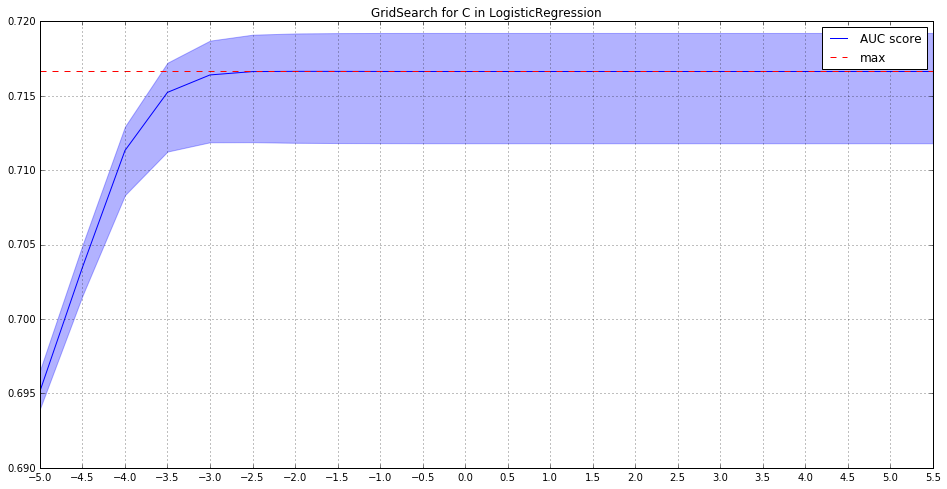

max(AUC): 0.716643, C=10^(-2.00)
CPU times: user 4min 39s, sys: 6.32 s, total: 4min 45s
Wall time: 3min 4s


In [7]:
%%time
scaler = StandardScaler().fit(data)
for x in [arange(-5,6,0.5)]:
    C_values = [10 ** y for y in x]
    results, results_max, results_min = [], [], []
    for C in C_values:
        tmp = cross_val_score(LogisticRegression(C=C), scaler.transform(data.ix[:,:]), 
                                 targets, scoring='roc_auc', cv=KF)
        results.append(tmp.mean())
        results_max.append(tmp.max())
        results_min.append(tmp.min())
    plt.figure(figsize=(16,8))
    plt.title('GridSearch for C in LogisticRegression')
    plt.xlim(x[0], x[-1])
    plt.fill_between(x, results_max, results_min, color='b', alpha=0.3)  
    plt.plot(x, results, color='b', label='AUC score')
    plt.plot(x, max(results) * ones(len(results)), linestyle='--', color='r', label='max')
    plt.legend(loc='best')
    plt.xticks(x)
    plt.grid()
    plt.show()
    print "max(AUC): %.6f, C=10^(%.2f)" % (max(results), x[argmax(results)])

_Создадим новый датасет, в котором не будет информации об используемых героях_

In [8]:
dataWithoutHeros = data.drop(['lobby_type'] + [x+str(y)+'_hero' for x in ['r','d'] for y in range(1,6)], axis=1)

_Подберём оптимальный параметр C для логистической регрессии для датасета без информации о героях_

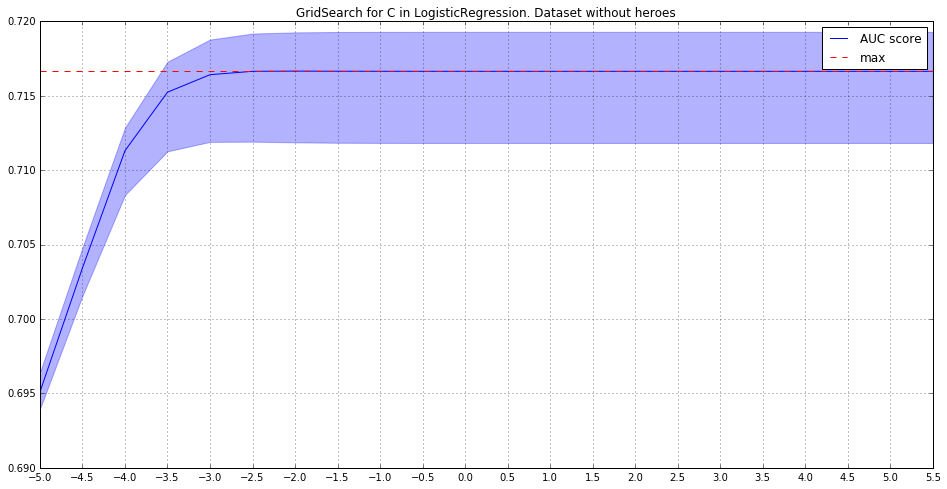

max(AUC): 0.716660, C=10^(-2.00)
CPU times: user 4min 17s, sys: 7.4 s, total: 4min 24s
Wall time: 2min 47s


In [9]:
%%time
scaler = StandardScaler().fit(dataWithoutHeros)
for x in [arange(-5,6,0.5)]:
    C_values = [10 ** y for y in x]
    results, results_max, results_min = [], [], []
    for C in C_values:
        tmp = cross_val_score(LogisticRegression(C=C), scaler.transform(dataWithoutHeros.ix[:,:]), 
                                 targets, scoring='roc_auc', cv=KF)
        results.append(tmp.mean())
        results_max.append(tmp.max())
        results_min.append(tmp.min())
    plt.figure(figsize=(16,8))
    plt.title('GridSearch for C in LogisticRegression. Dataset without heroes')
    plt.xlim(x[0], x[-1])
    plt.fill_between(x, results_max, results_min, color='b', alpha=0.3)  
    plt.plot(x, results, color='b', label='AUC score')
    plt.plot(x, max(results) * ones(len(results)), linestyle='--', color='r', label='max')
    plt.legend(loc='best')
    plt.xticks(x)
    plt.grid()
    plt.show()
    print "max(AUC): %.6f, C=10^(%.2f)" % (max(results), x[argmax(results)])

total 108 unique heroes


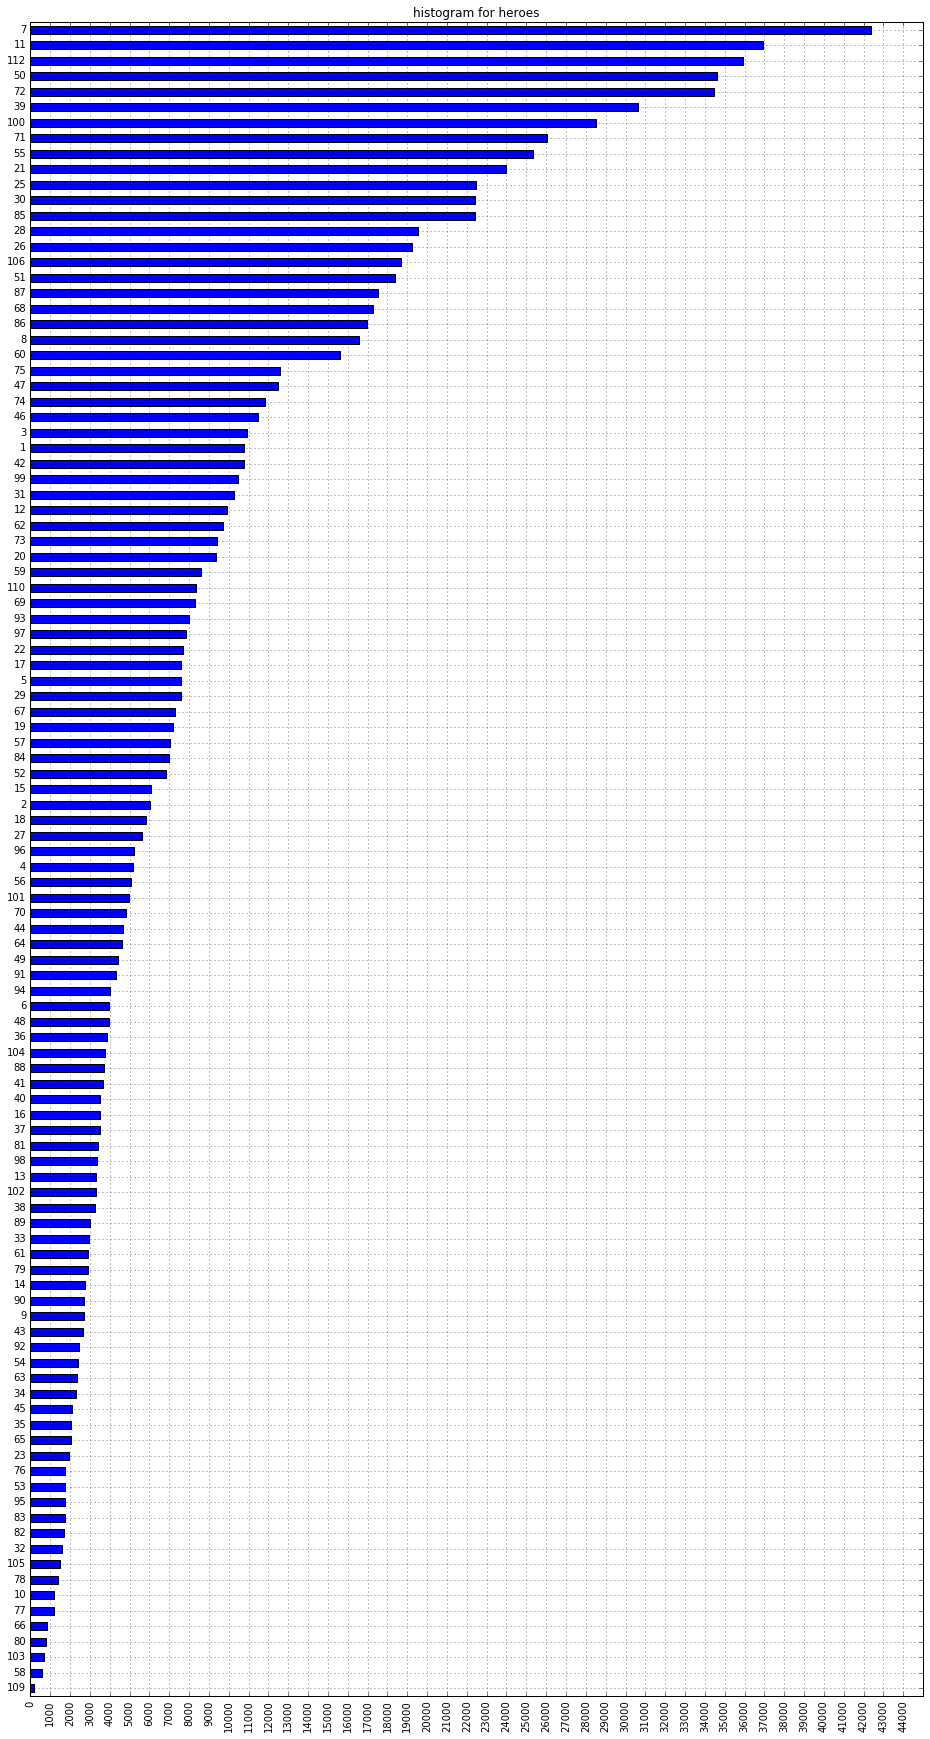

In [10]:
heroes = pd.Series(name='hero')
for x in [x+str(y)+'_hero' for x in ['r','d'] for y in range(1,6)]:
    heroes = heroes.append(data[x])
print "total %d unique heroes" % len(heroes.unique())
heroes.value_counts()[::-1].plot(kind='barh', figsize=(16,30), title='histogram for heroes')
plt.grid()
plt.xticks(range(0,45000,1000), rotation='vertical')
plt.show()

In [11]:
print "list of heroes:\n" +" ".join(map(str, sorted(heroes.unique())))

list of heroes:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 109 110 112


In [12]:
%%time
N = heroes.max()
X_pick = np.zeros((data.shape[0], N))
for i, match_id in enumerate(data.index):
    for p in xrange(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

CPU times: user 4.16 s, sys: 12 ms, total: 4.18 s
Wall time: 4.17 s


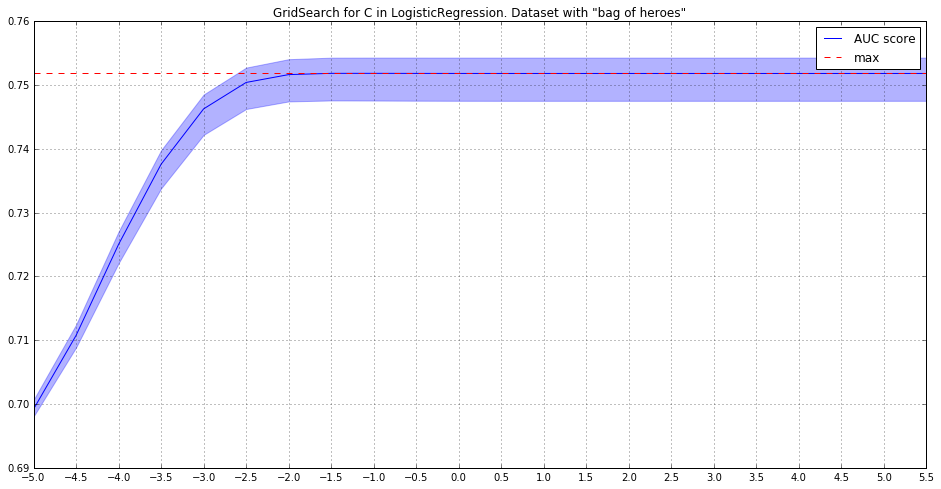

max(AUC): 0.751855, C=10^(-1.00)
CPU times: user 7min 20s, sys: 7.8 s, total: 7min 28s
Wall time: 5min 49s


In [13]:
%%time
scaler = StandardScaler().fit(dataWithoutHeros)
for x in [arange(-5,6,0.5)]:
    C_values = [10 ** y for y in x]
    results, results_max, results_min = [], [], []
    for C in C_values:
        tmp = cross_val_score(LogisticRegression(C=C), np.hstack((scaler.transform(dataWithoutHeros.ix[:,:]), X_pick)),
                                 targets, scoring='roc_auc', cv=KF)
        results.append(tmp.mean())
        results_max.append(tmp.max())
        results_min.append(tmp.min())
    plt.figure(figsize=(16,8))
    plt.title('GridSearch for C in LogisticRegression. Dataset with "bag of heroes"')
    plt.xlim(x[0], x[-1])
    plt.fill_between(x, results_max, results_min, color='b', alpha=0.3)  
    plt.plot(x, results, color='b', label='AUC score')
    plt.plot(x, max(results) * ones(len(results)), linestyle='--', color='r', label='max')
    plt.legend(loc='best')
    plt.xticks(x)
    plt.grid()
    plt.show()
    print "max(AUC): %.6f, C=10^(%.2f)" % (max(results), x[argmax(results)])

_Загрузим тестовую выборку, заполним нулями отсутствующие значения, удалим информацию о героях и типе лобби, создадим мешок героев для тестовой выборки._

_Затем обучим логистическую регрессию на тренировочной выборке со стандартизированными признаками и мешком слов, будем использовать параметр C, подобранный по кросс-валидации, проведённой выше._

_Сделаем предсказанния вероятностей победы команды radiant для тестовой выборки со стандартизированными признаками и мешком слов, запишем предсказания в файл и пошлём на Kaggle._

In [14]:
%%time
dataTest = pd.read_csv('features_test.csv', index_col='match_id')
dataTest.fillna(0., inplace=True)

dataTestWithoutHeros = dataTest.drop(['lobby_type'] + [x+str(y)+'_hero' for x in ['r','d'] for y in range(1,6)], axis=1)

X_pick_test = np.zeros((dataTest.shape[0], N))
for i, match_id in enumerate(dataTest.index):
    for p in xrange(5):
        X_pick_test[i, dataTest.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test[i, dataTest.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

scaler = StandardScaler().fit(dataWithoutHeros)
LR = LogisticRegression(C=10**-1)
LR.fit(hstack((scaler.transform(dataWithoutHeros), X_pick)), targets)

LR.predict_proba(hstack((scaler.transform(dataTestWithoutHeros), X_pick_test)))[:,1]

results = pd.DataFrame(index=dataTest.index, 
                       data = LR.predict_proba(hstack((scaler.transform(dataTestWithoutHeros), X_pick_test)))[:,1],
                       columns=['radiant_win'])

results.to_csv('predictions.csv')

IOError: File features_test.csv does not exist

_Получили __AUC 0.75529__ _

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?

#Отчёт по логистической регрессии
1. Качество логистической регрессии над всеми исходными признаками получилось 0.716416. Качество получилось лучше, чем у градиентного бустинга. Возможно, линейные методы работают лучше логических на данном наборе данных. Да, логистическая регрессия обучается быстрее градиентного бустинга.
2. Качество логистической регрессии над всеми признаками, кроме типа лобби и героев, получилось 0.716430. Качество улучшилось, потому модель рассматривала категориальный признак, как числовой. А так делать нельзя.
3. 108 различных героев (см. гистограмму и список)
4. При добавлении мешка слов качество улучшилось до 0.751904. Да, качество улучшилось. Улучшилось, потому что мы используем правильным образом важную для этой задачи информацию.